In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset,DataLoader

import os

import umap
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA

from src.models import VAE
from src.training import Trainer

import pandas as pd
import seaborn as sns

from src.visualization import *

In [2]:
data_path = '/stor/huakui/research/VB/ghx/joint-vae/datasets/Endothelial_combine'
train = torch.load(os.path.join(data_path,'train_dataset.pt'))
val = torch.load(os.path.join(data_path,'val_dataset.pt'))

In [3]:
latent_spec = {'cont': 5,'disc': [4,4,5,6]}
model = VAE(latent_spec=latent_spec, data_size = (2000,1), use_cuda = torch.cuda.is_available())
# Build optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# Define the capacities
# Continuous channels
cont_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
# Discrete channels
disc_capacity = [0.0, 5.0, 25000, 30.0]  # Starting at a capacity of 0.0, increase this to 5.0
                                         # over 25000 iterations with a gamma of 30.0
    # Build a trainer
trainer = Trainer(model, optimizer,
                  cont_capacity=cont_capacity,disc_capacity=disc_capacity,
                  clustering_lambda = 0.001, cluster_disc_dims = [0,1],
                  diffusion_lambda=1, diffuse_cont_dims = [0,1], 
                  sigma = 5, random_walk_step = 1,
                  discrete_supervised_lambda = 100, disc_supervise_dict = {0:0},
                  continuous_supervised_lambda = 100, cont_supervise_dict = {0:2},
                  print_loss_every=100, record_loss_every=5,
                  use_cuda = torch.cuda.is_available(), verbose = False)
train_loader = DataLoader(train, batch_size=128,shuffle=True)
# Train model for 10 epochs
# Note this should really be a 100 epochs and trained on a GPU, but this is just to demo
trainer.train(train_loader, epochs=50)

Epoch 50: 100%|██████████| 50/50 [01:07<00:00,  1.34s/it, Epoch_average_loss=1455.0062280352945]


In [4]:
for data in DataLoader(train,batch_size=len(train),shuffle=False):
    break 
x = data[0].view(data[0].size(0),-1).cuda()
with torch.no_grad():
    latent_sample,latent_dist = model(x)
z_hat = torch.argmax(latent_dist['disc'][0],dim = 1)
# pca = PCA(n_components=50)
# pca.fit(data[0].detach().cpu())
# pcs = pca.transform(data[0].detach().cpu())
# np.save(file = '/stor/huakui/research/EC_coordinate_system/exploratory.pca.npy', 
#          arr = pcs)

In [63]:
for data in DataLoader(train,batch_size=len(train),shuffle=False):
    break 
mtx, label = data

In [77]:
data

[tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 1.6037, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 1.2774, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor([[2.0000e+00, 0.0000e+00, 4.8987e-02],
         [1.0000e+00, 0.0000e+00, 4.9047e-02],
         [1.0000e+00, 4.0000e+00, 1.5961e-02],
         ...,
         [1.0000e+00, 0.0000e+00, 5.1756e-02],
         [0.0000e+00, 0.0000e+00, 4.9513e-02],
         [1.0000e+00, 4.0000e+00, 3.1825e-03]], dtype=torch.float64)]

In [68]:
disc_supervise_dict = {0:0}
for latent in disc_supervise_dict:
    attribute = label[:,disc_supervise_dict[latent]]
    attribute = attribute.type(torch.int64)
    if False:
        attribute = attribute.cuda()

In [75]:
attribute

tensor([2, 1, 1,  ..., 1, 0, 1])

In [70]:
np.unique(attribute)

array([0, 1, 2, 3])

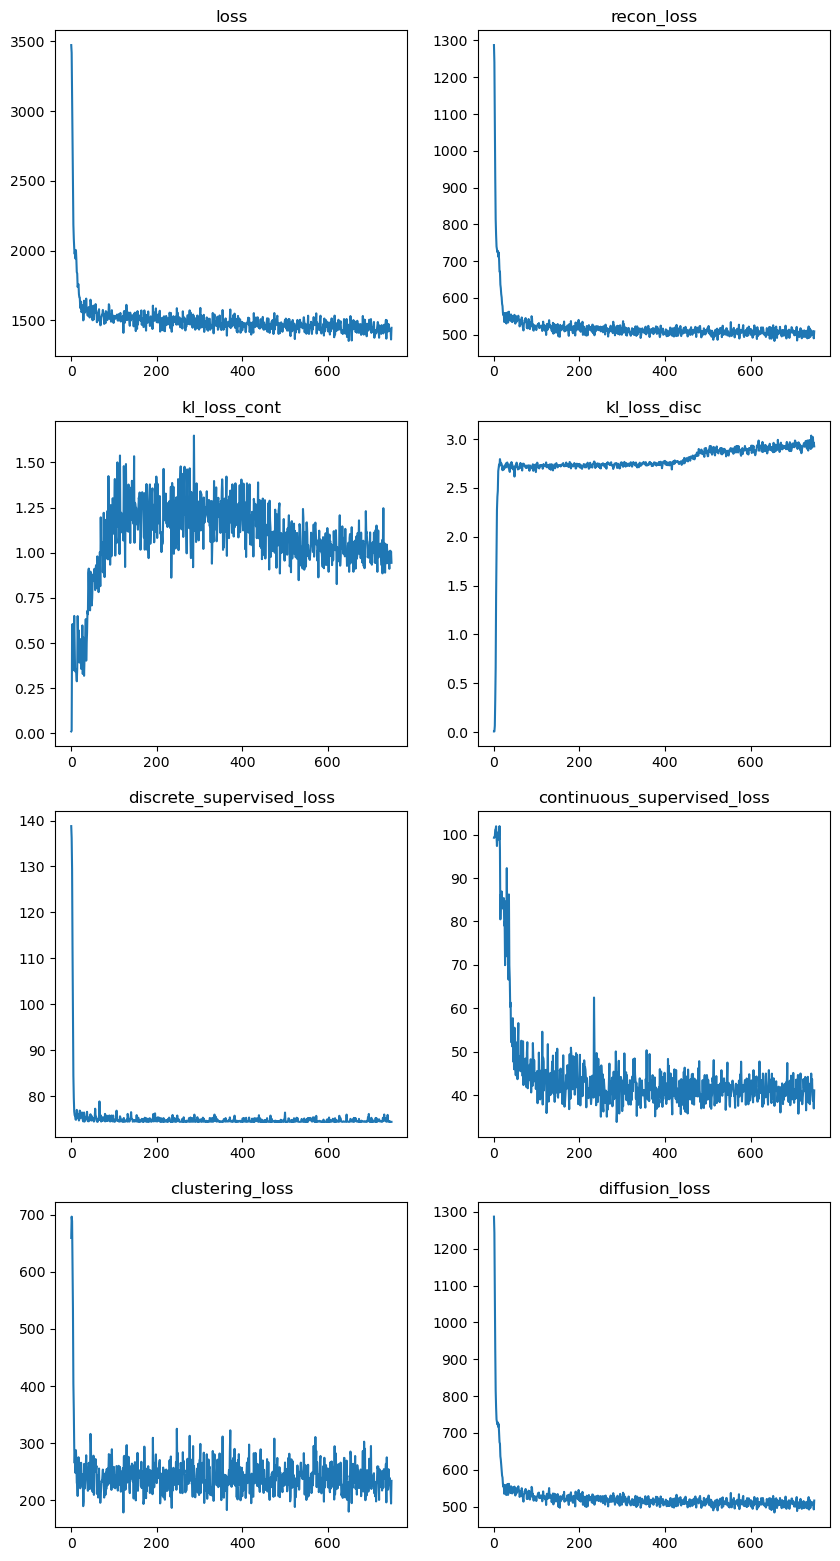

In [5]:
fig = draw_loss_curves(trainer.losses)
fig.show()

In [ ]:
# discrete labels
labels_disc = pd.DataFrame()
group_index = {0:'heart',1:'liver',2:'brain',3:'testis'}
label = data[1][:,0].int()
labels_disc['True Label'] = [group_index[int(i)] for i in data[1][:,0].int()]
for idx in range(len(latent_dist['disc'])):
    label_hat = torch.argmax(latent_dist['disc'][idx].detach().cpu(),dim = 1)
    labels_disc['disc_dim_'+str(idx)] = np.array(label_hat)
# continuous labels
max_draw_cont = 5
labels_cont = pd.DataFrame()
labels_cont['True label'] = np.array(data[1][:,2])
for idx in range(latent_dist['cont'][0].shape[1]):
    if idx > max_draw_cont-1:
        break
    label_hat = latent_dist['cont'][0][:,idx].detach().cpu()
    labels_cont['cont_dim_'+str(idx)] = np.array(label_hat)

In [ ]:
pcs = np.load('/stor/huakui/research/EC_coordinate_system/exploratory.pca.npy')

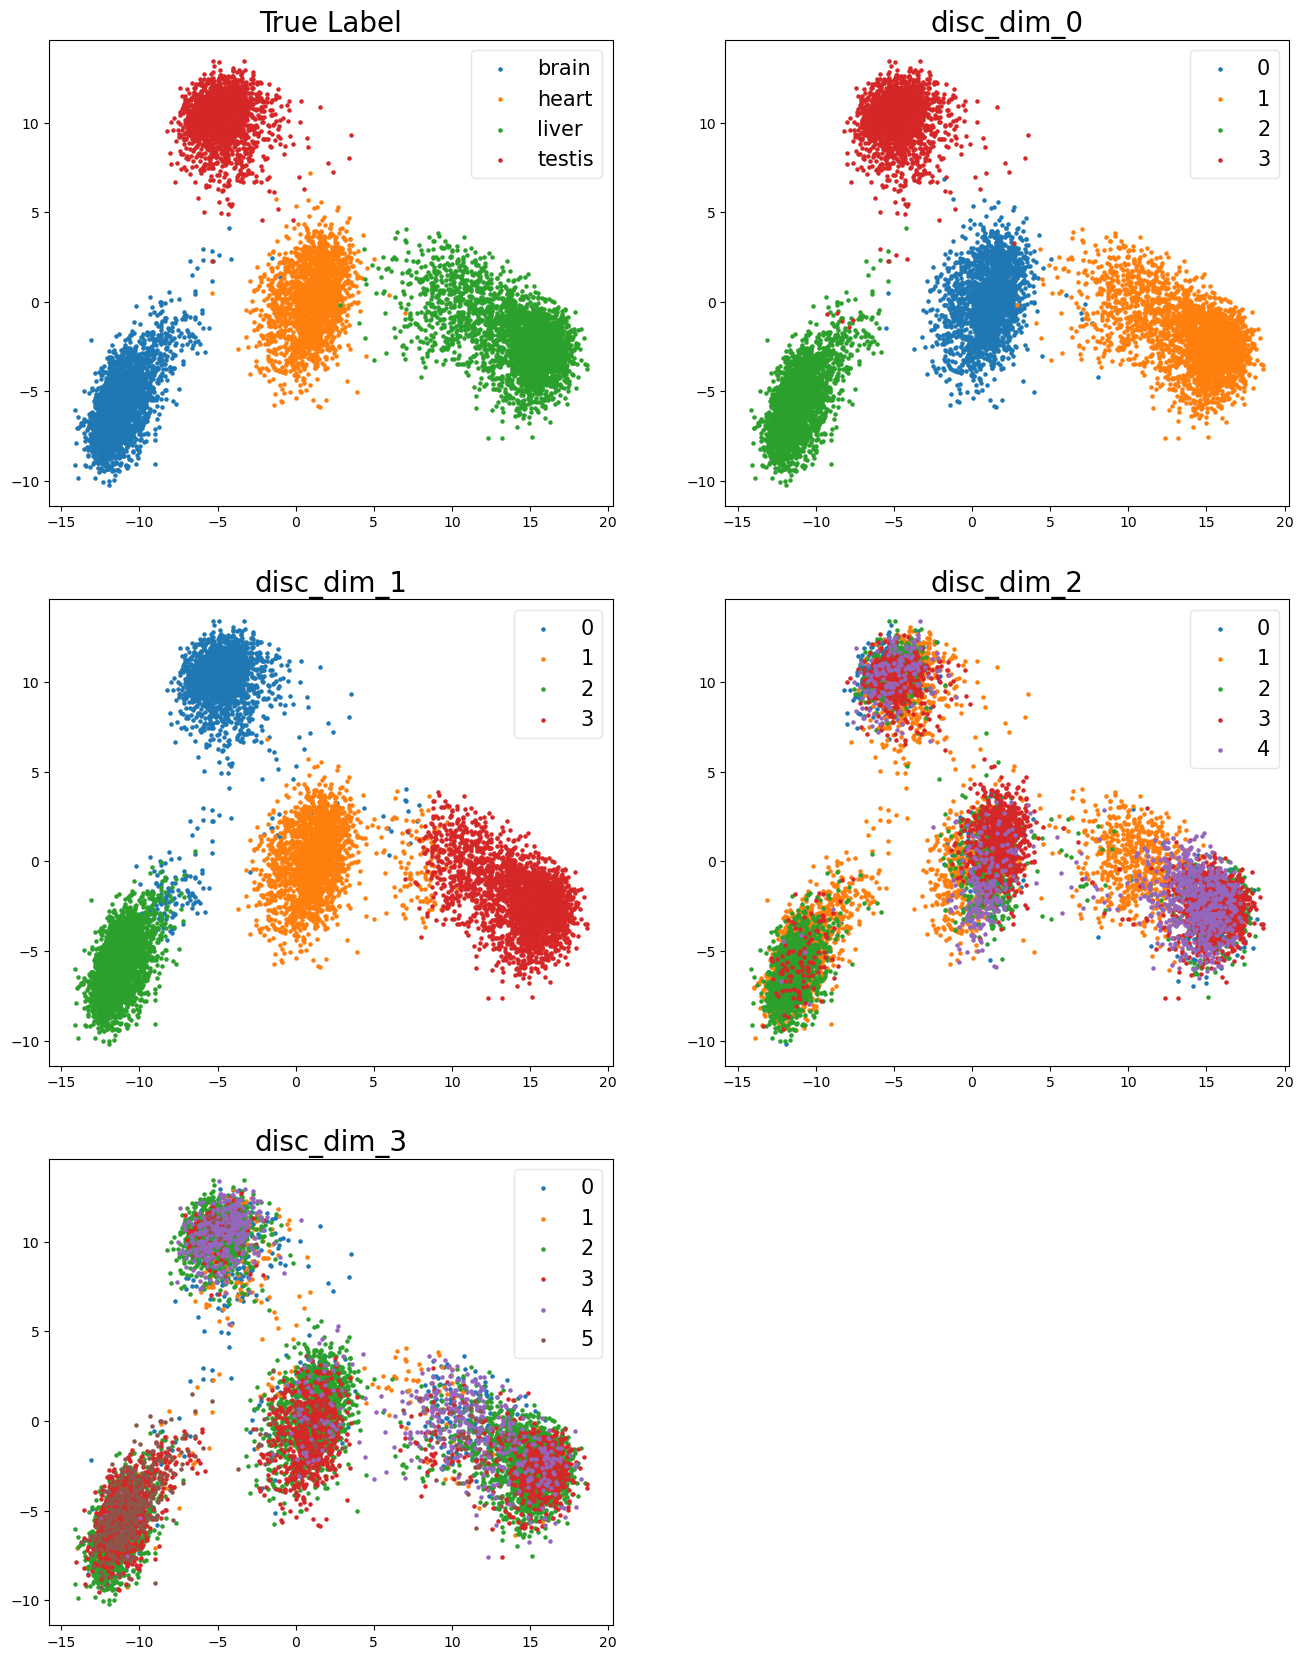

In [12]:
fig = draw_scatter_with_discrete_labels(pcs, labels_disc)
fig.show()

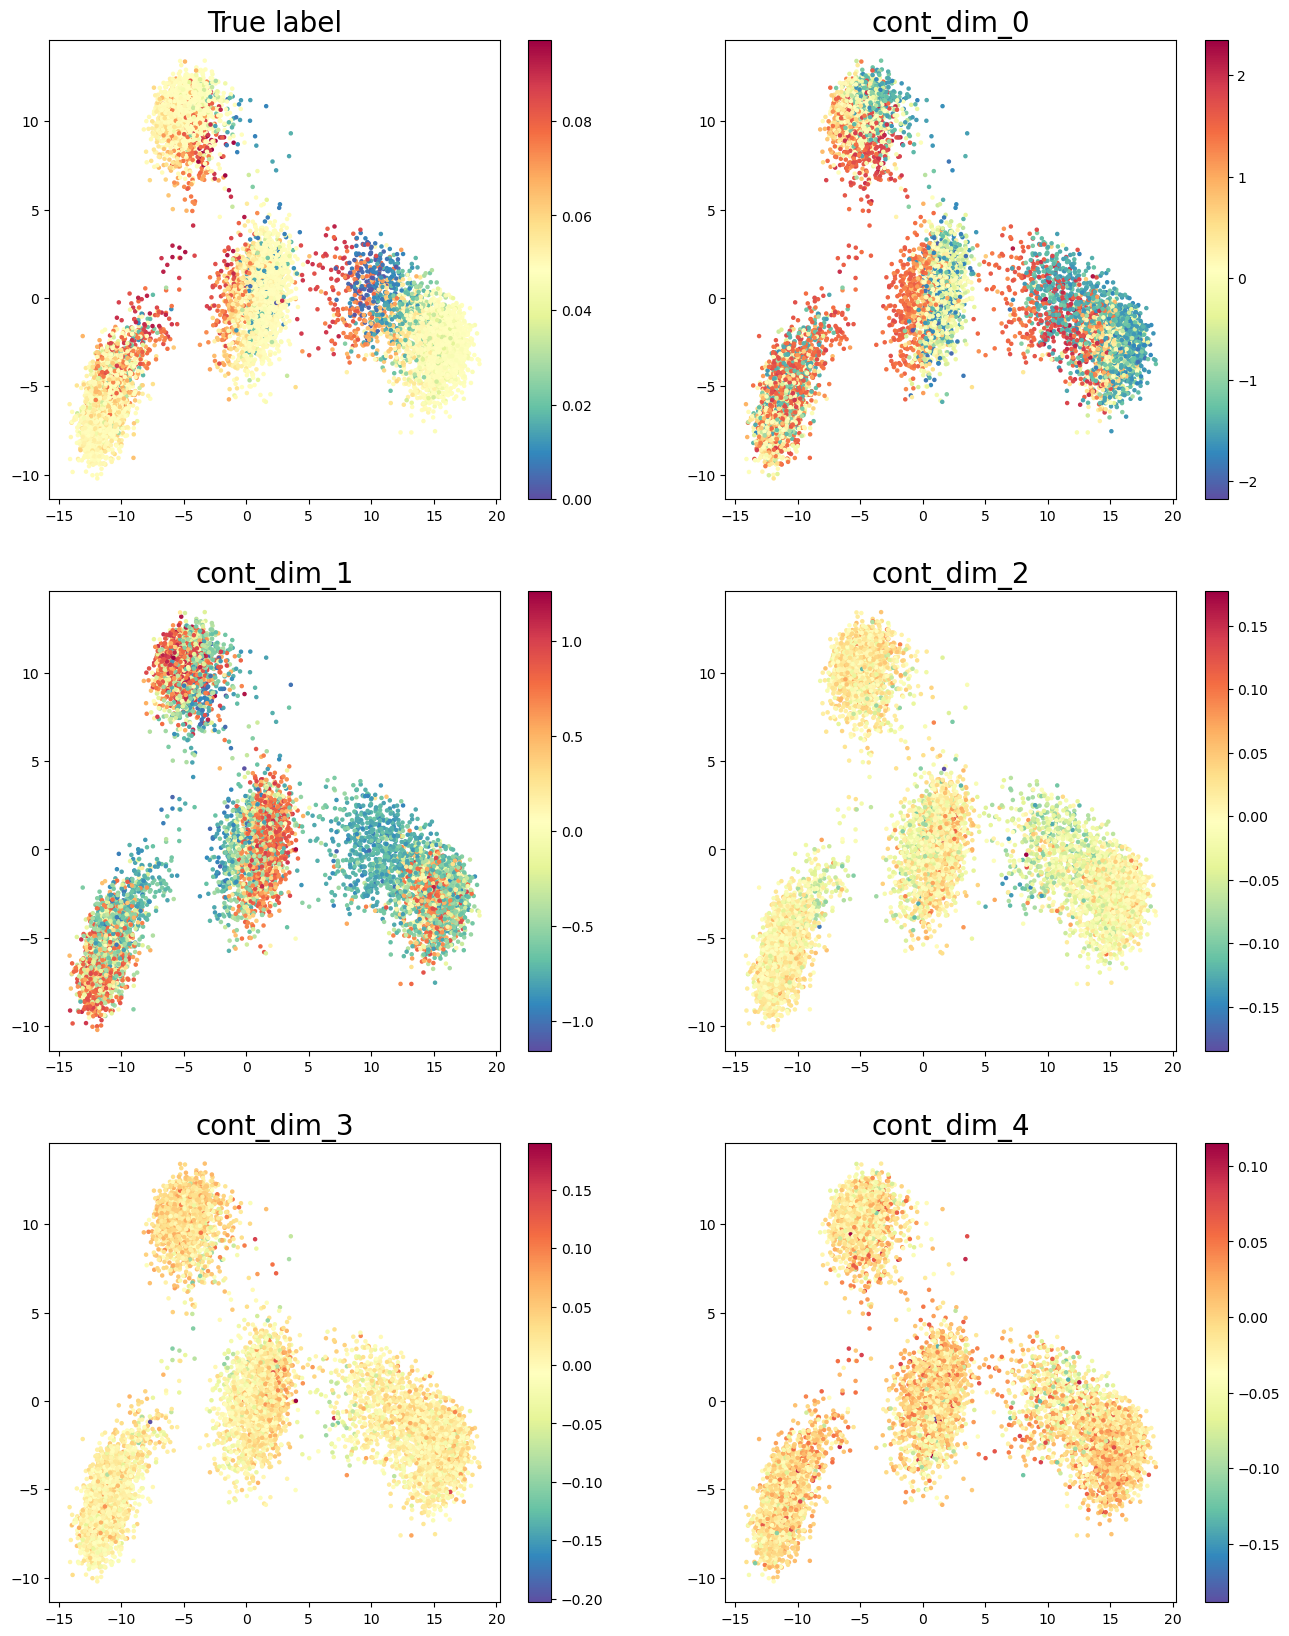

In [47]:
fig = draw_scatter_with_continuous_labels(pcs, labels_cont)
fig.show()

In [ ]:
# u  = umap.UMAP().fit_transform(pcs)
# np.save(file = '/stor/huakui/research/EC_coordinate_system/exploratory.umap.npy', 
#         arr = u)
u = np.load('/stor/huakui/research/EC_coordinate_system/exploratory.umap.npy')

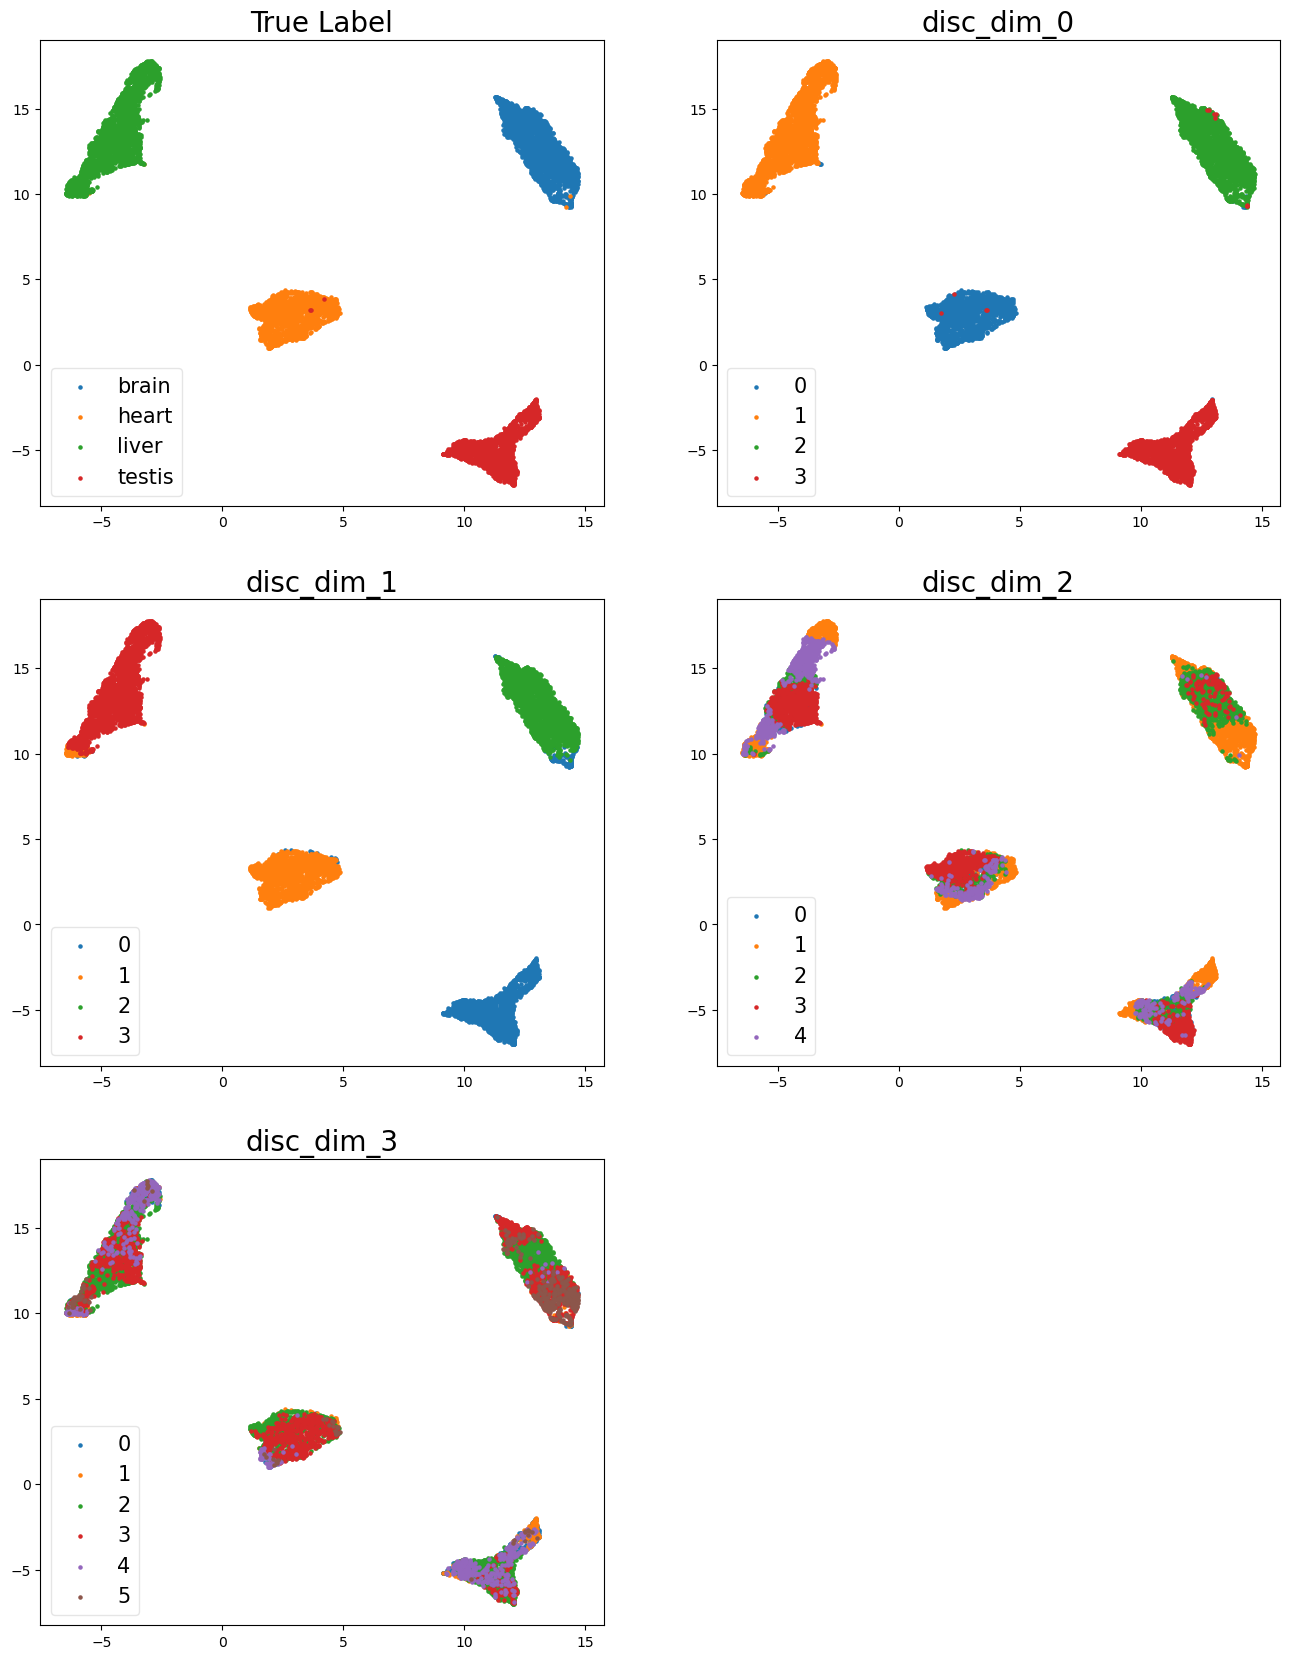

In [13]:
fig = draw_scatter_with_discrete_labels(u, labels_disc)
fig.show()

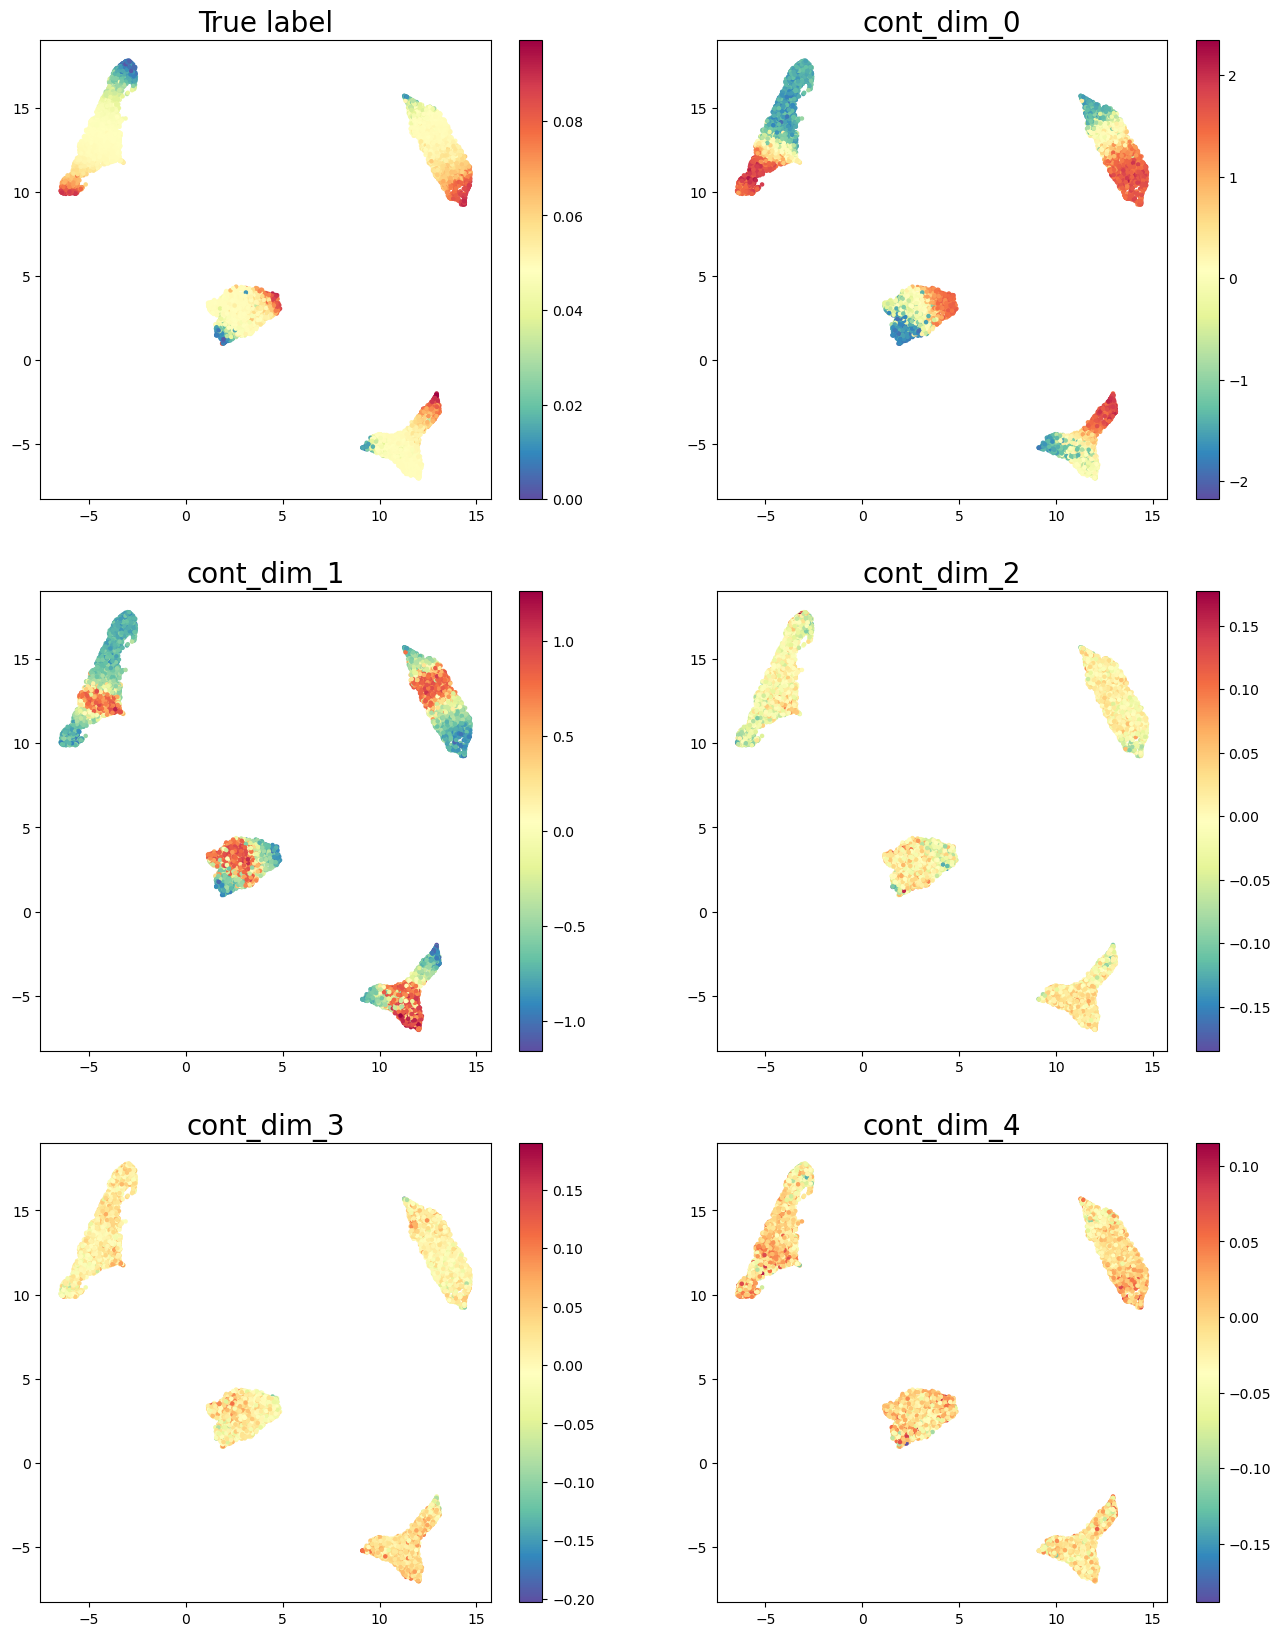

In [14]:
fig = draw_scatter_with_continuous_labels(u, labels_cont)
fig.show()

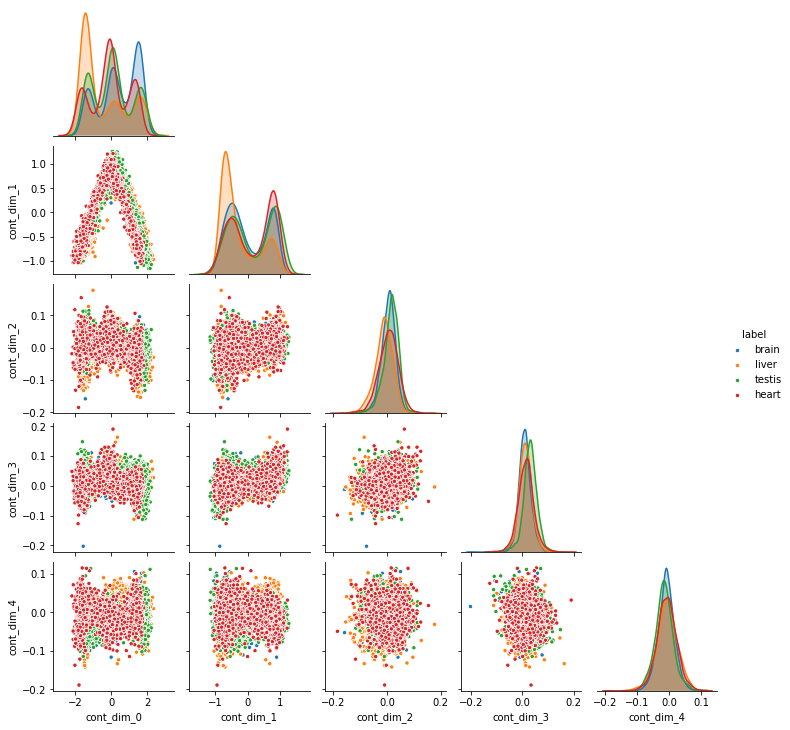

In [48]:
max_draw_cont = 5
embeddings = np.array(latent_dist['cont'][0].cpu())
embeddings = embeddings[:,0:min(max_draw_cont, len(embeddings))]
embeddings = pd.DataFrame(embeddings)
embeddings.columns = ['cont_dim_'+str(idx) for idx in embeddings.columns]
embeddings['label'] = [group_index[int(i)] for i in data[1][:,0].int()]

fig = sns.pairplot(embeddings,hue="label", plot_kws={'size':1}, height = 2, aspect = 1, corner=True)
plt.show()

In [17]:
latent_u  = umap.UMAP().fit_transform(latent_dist['cont'][0].cpu())

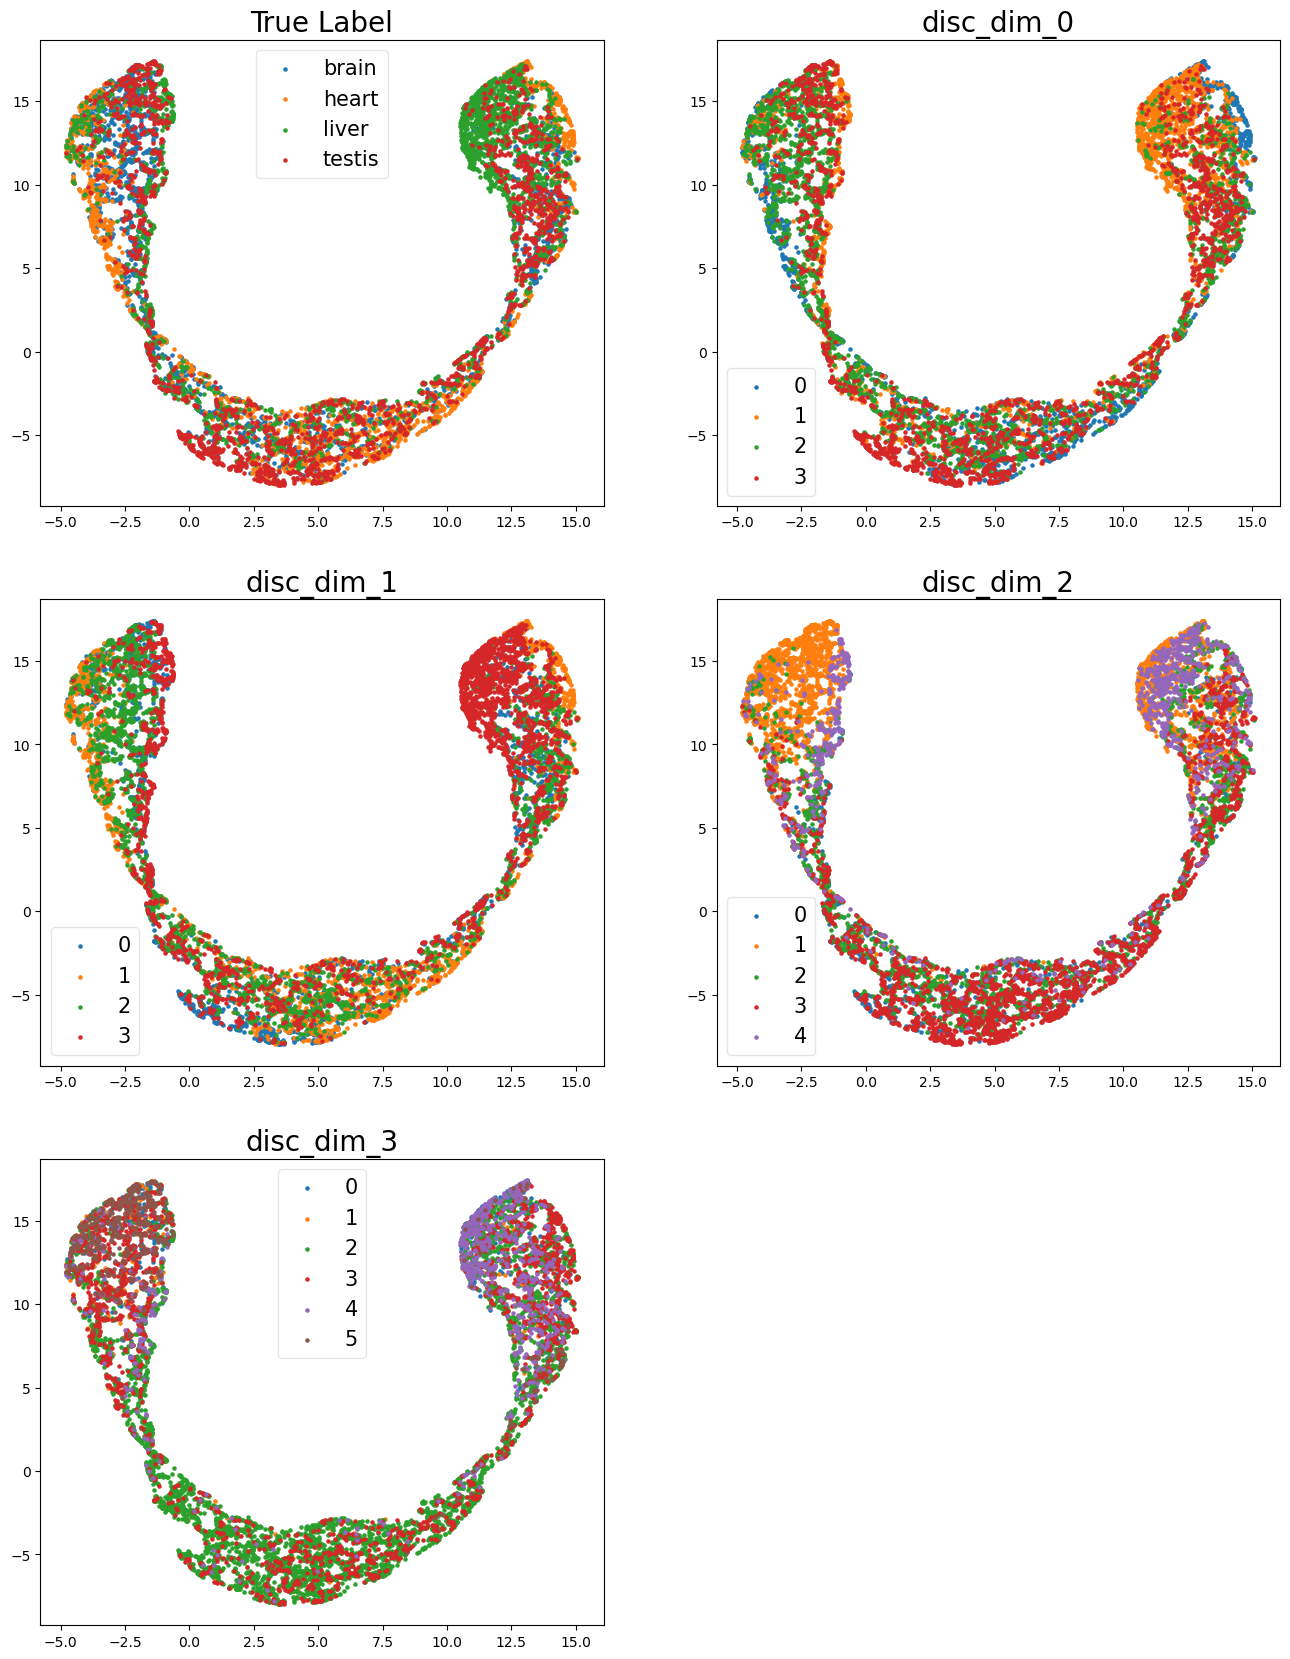

In [18]:
fig = draw_scatter_with_discrete_labels(latent_u, labels_disc)
fig.show()

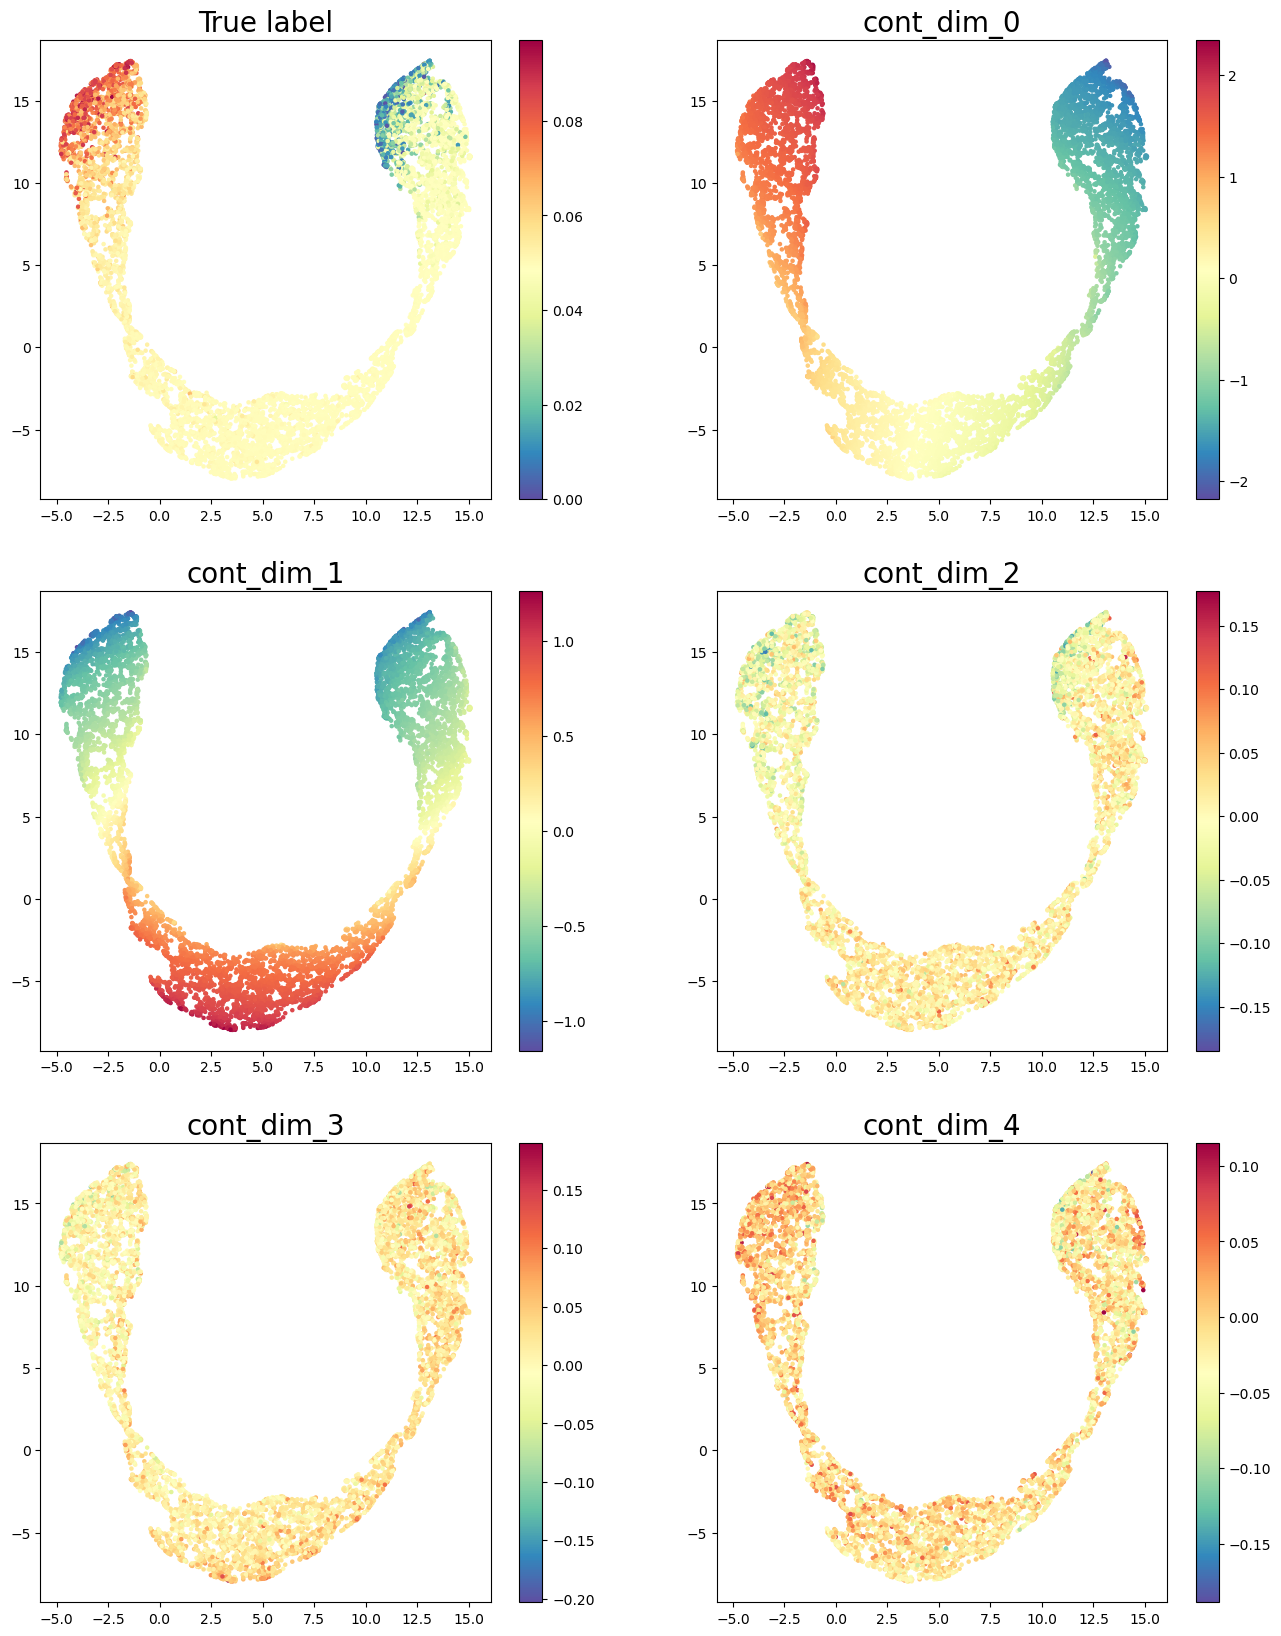

In [19]:
fig = draw_scatter_with_continuous_labels(latent_u, labels_cont)
fig.show()

In [88]:
import copy

In [89]:
model1 = copy.deepcopy(model)

In [90]:
optimizer1 = optim.Adam(model.parameters(), lr=5e-4)

In [ ]:
for data in DataLoader(train,batch_size=len(train),shuffle=False):
    break 
x = data[0].view(data[0].size(0),-1).cuda()
with torch.no_grad():
    latent_sample,latent_dist = model(x)

In [93]:
trainer1 = Trainer(model1, optimizer1,
                  cont_capacity=cont_capacity,disc_capacity=disc_capacity,
                  clustering_lambda = 0.001, cluster_disc_dims = [0,1],
                  diffusion_lambda=1, diffuse_cont_dims = [0,1], 
                  sigma = 5, random_walk_step = 1,
                  discrete_supervised_lambda = 100, disc_supervise_dict = {0:0},
                  continuous_supervised_lambda = 100, cont_supervise_dict = {0:2},
                  print_loss_every=100, record_loss_every=5,
                  use_cuda = torch.cuda.is_available(), verbose = False)
train_loader1 = DataLoader(val, batch_size=len(val),shuffle=False)
# Train model for 10 epochs
# Note this should really be a 100 epochs and trained on a GPU, but this is just to demo
trainer1.train(train_loader1, epochs=1)

Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s, Epoch_average_loss=1488.7526035308838]


In [94]:
trainer1.losses

{'loss': [1488.7525634765625],
 'recon_loss': [506.3682861328125],
 'kl_loss_cont': [0.9112868905067444],
 'kl_loss_cont_0': [0.7139203548431396],
 'kl_loss_cont_1': [0.19487927854061127],
 'kl_loss_cont_2': [0.0008277559536509216],
 'kl_loss_cont_3': [0.0008972084033302963],
 'kl_loss_cont_4': [0.000762254698202014],
 'kl_loss_disc': [2.9505929946899414],
 'kl_loss_disc_0': [1.3811997175216675],
 'kl_loss_disc_1': [1.3636432886123657],
 'kl_loss_disc_2': [0.20374023914337158],
 'kl_loss_disc_3': [0.002009868621826172],
 'discrete_supervised_loss': [74.49916076660156],
 'continuous_supervised_loss': [43.85968017578125],
 'clustering_loss': [239.37060546875],
 'diffusion_loss': [508.8105163574219]}

In [95]:
torch.save(model, os.path.join('/stor/huakui/research/VB/ghx/joint-vae/test', 'oldmodel.pth'))

In [96]:
for data in train_loader1:
    break

In [97]:
data

[tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 1.8044, 1.8044,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.8129, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor([[2.0000, 0.0000, 0.0567],
         [0.0000, 3.0000, 0.0787],
         [0.0000, 0.0000, 0.0498],
         ...,
         [0.0000, 0.0000, 0.0489],
         [2.0000, 1.0000, 0.0496],
         [1.0000, 0.0000, 0.0471]], dtype=torch.float64)]